In [1]:
import os
import sys
home_dir = "../../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
from models.aa_common.performance_metrics import *

In [10]:
task = "pathogenic" # pathogenic, likely_pathogenic
model_root_and_name_tuple_list = [("dbnsfp", "sift"), ("dbnsfp", "polyphen2_HVAR"), ("dbnsfp", "cadd"), ("dbnsfp", "mvp"), ("dbnsfp", "metarnn"), ("dbnsfp", "revel"),
                                  ("tape_rao", "unirep"), ("tape_rao", "protbert"), ("sequnet_dunham", "sequnet"), 
                                  ("esm_rives", "esm1b_t33_650M_UR50S"), ("esm_rives", "esm1v_t33_650M_UR90S"), ("esm_rives", "esm2_t33_650M_UR50D"),
                                  ("bioembeddings_dallago", "plus_rnn"), 
                                  ("bioembeddings_dallago", "prottrans_bert_bfd"), ("bioembeddings_dallago", "prottrans_albert_bfd"),
                                  ("bioembeddings_dallago", "prottrans_xlnet_uniref100"), 
                                  ("bioembeddings_dallago", "prottrans_t5_bfd"), ("bioembeddings_dallago", "prottrans_t5_uniref50"), ("bioembeddings_dallago", "prottrans_t5_xl_u50"),
                                  ("", "conservation")]
# model_root_and_name_tuple_list = [("dbnsfp", "polyphen2_HVAR")]
# by default, we consider larger means positive class (here pathogenic or likely-pathogenic), but the following models have specific opposite meaning
models_smaller_means_damaging = ["sequnet", "sift"]

metrics = ["AUC-ROC", "AUC-PR", "F1-max", "Th-max", "Precision", "Recall", "Accuracy", "Balanced-accuracy", "MCC", "Missing values (%)"]

In [12]:
list_of_resut_df = []
for analysis_no in range(10):
    result_df = pd.read_csv(home_dir+f"models/aa_common/merged_predictions/{task}_analysis/{analysis_no}.csv", sep="\t")
    
    result_df.loc[result_df["class"]==task, "class_numeric"] = 1
    result_df.loc[result_df["class"]=="neutral", "class_numeric"] = 0
    
    list_of_resut_df.append(result_df)
    
print(list_of_resut_df[0].shape)
print(list_of_resut_df[0].columns)

(4586, 31)
Index(['id', 'chrom_acc_version', 'chrom_pos', 'ref_allele', 'alt_allele',
       'prot_acc_version', 'prot_pos', 'wt', 'mut', 'class', 'sift_pred',
       'polyphen2_HVAR_pred', 'cadd_pred', 'mvp_pred', 'metarnn_pred',
       'revel_pred', 'unirep_pred', 'protbert_pred', 'sequnet_pred',
       'esm1b_t33_650M_UR50S_pred', 'esm1v_t33_650M_UR90S_pred',
       'esm2_t33_650M_UR50D_pred', 'plus_rnn_pred', 'prottrans_bert_bfd_pred',
       'prottrans_albert_bfd_pred', 'prottrans_xlnet_uniref100_pred',
       'prottrans_t5_bfd_pred', 'prottrans_t5_uniref50_pred',
       'prottrans_t5_xl_u50_pred', 'conservation_pred', 'class_numeric'],
      dtype='object')


### For debugging purpose only

	AUC-ROC: 0.177
	AUC-PR: 0.808
(8302,)
	Best F1-Score: 0.769 at threshold: -0.508
	AUC-PR: 0.502
	Best F1-Score: 0.667 at threshold: 0.001


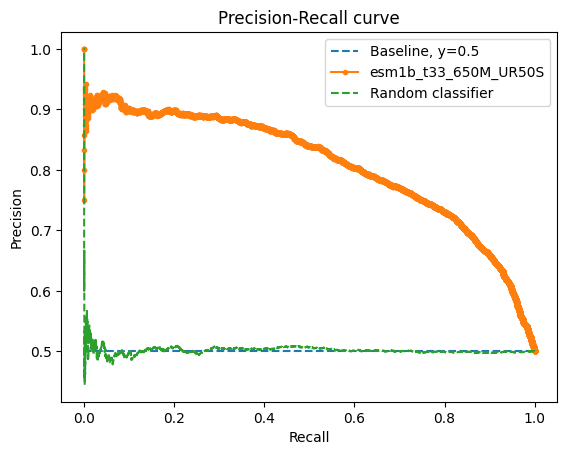

In [7]:
result_df = list_of_resut_df[0]
model_name = "esm1b_t33_650M_UR50S" # polyphen2_HVAR, esm1b_t33_650M_UR50S
model_pred_col = model_name + "_pred"

result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]

non_nan_result_df = result_df[~pd.isna(result_df[model_pred_col])]  # taking df for only non-NAN values

if model_name in models_smaller_means_damaging:
    non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)

auc_roc_score, larger_means_positive_class = get_auc_roc_score(non_nan_result_df)
if not larger_means_positive_class:
    non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)

auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
print(thresholds.shape)
f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)

# f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th_(non_nan_result_df)

# print(thresholds.shape)
# print(precisions)
# print(recalls)

import matplotlib.pyplot as plt
plt.plot([0,1], [.5, .5], linestyle='--', label='Baseline, y=0.5')# precisions_list.append(p)
plt.plot(recalls, precisions, marker='.', label=f'{model_name}')


import random
result_df["pred"] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
non_nan_result_df = result_df[~pd.isna(result_df[model_pred_col])]  # taking df for only non-NAN values
auc_pr_score, p, r, t = get_auc_pr_score(non_nan_result_df)
f1_max, th_max, p, r, t = get_f1max_and_th(p, r, t)
plt.plot(r, p, linestyle='--', label="Random classifier")


plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()
plt.title("Precision-Recall curve")
plt.show()


# pathogenicity = result_df[result_df["class"]==task]
# neutral = result_df[result_df["class"]=="neutral"]

# bins = 100 # 20, 100, 500
# plt.hist(pathogenicity["pred"], bins=bins, density=False, log=False, alpha=.6, label=f"Pathogenicity-{model_name}")
# plt.hist(neutral["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"Neutral-{model_name}")

# plt.legend()
# plt.show()

In [13]:
performance_scores_sum_dict = {}

for analysis_no, result_df in enumerate(list_of_resut_df):
    output_file = home_dir+f"models/aa_common/performance_analysis/{task}_analysis/{analysis_no}.csv"

    out = open(output_file, 'w')
    out.write("Models\\Metrics")
    for metric in metrics:
        out.write(f"\t{metric}")
    out.write("\n")


    for i, (model_root, model_name) in enumerate(model_root_and_name_tuple_list):
        print(model_name)
        model_pred_col = model_name + "_pred"
        result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]
        
        missing_values_percentage = (result_df[pd.isna(result_df[model_pred_col])].shape[0] / result_df.shape[0]) * 100
        print(f"\tMissing values: {result_df[pd.isna(result_df[model_pred_col])].shape[0]} / {result_df.shape[0]}")
        
        non_nan_result_df = result_df[~pd.isna(result_df[model_pred_col])]  # taking df for only non-NAN values
        
        if model_name in models_smaller_means_damaging: # this is we know from papers
            non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
        
        auc_roc_score, larger_means_positive_class = get_auc_roc_score(non_nan_result_df)
        if not larger_means_positive_class:
            non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)

        auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
        f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)
        precision = get_precision_score(non_nan_result_df, th_max)
        recall = get_recall_score(non_nan_result_df, th_max)
        accuracy = get_accuracy_score(non_nan_result_df, th_max)
        balanced_accuracy = get_balanced_accuracy_score(non_nan_result_df, th_max)
        mcc = get_matthews_corrcoef(non_nan_result_df, th_max)
        
        permformance_scores = [auc_roc_score, auc_pr_score, f1_max, th_max, precision, recall, accuracy, balanced_accuracy, mcc, missing_values_percentage]
        
        out.write(f"{model_name}")
        for score in permformance_scores:
            out.write(f"\t{score:.3f}")
        out.write("\n")
            
        if model_name not in performance_scores_sum_dict:
            performance_scores_sum_dict[model_name] = np.array(permformance_scores)
        else: performance_scores_sum_dict[model_name] += np.array(permformance_scores)
        # if i==5: break

    out.close()

    
output_file = home_dir+f"models/aa_common/performance_analysis/{task}_analysis/avg.csv"
out = open(output_file, 'w')
out.write("Models\\Metrics")
for metric in metrics:
    out.write(f"\t{metric}")
out.write("\n")
    
for model_name, permformance_scores_sum in performance_scores_sum_dict.items():
    out.write(f"{model_name}")
    for score in permformance_scores_sum:
        out.write(f"\t{score/10:.3f}")
    out.write("\n")
out.close()

sift
	Missing values: 596 / 4586
	AUC-ROC: 0.815
	AUC-PR: 0.803
	Best F1-Score: 0.764 at threshold: -0.031
	Precision score: 0.669 at threshold: -0.031
	Recall score: 0.890 at threshold: -0.031
	Accuracy score: 0.731 at threshold: -0.031
	Balanced accuracy score: 0.735 at threshold: -0.031
	MCC score: 0.492 at threshold: -0.031
polyphen2_HVAR
	Missing values: 671 / 4586
	AUC-ROC: 0.792
	AUC-PR: 0.769
	Best F1-Score: 0.749 at threshold: 0.598
	Precision score: 0.678 at threshold: 0.598
	Recall score: 0.835 at threshold: 0.598
	Accuracy score: 0.724 at threshold: 0.598
	Balanced accuracy score: 0.726 at threshold: 0.598
	MCC score: 0.463 at threshold: 0.598
cadd
	Missing values: 475 / 4586
	AUC-ROC: 0.785
	AUC-PR: 0.732
	Best F1-Score: 0.754 at threshold: 0.502
	Precision score: 0.667 at threshold: 0.502
	Recall score: 0.867 at threshold: 0.502
	Accuracy score: 0.722 at threshold: 0.502
	Balanced accuracy score: 0.725 at threshold: 0.502
	MCC score: 0.468 at threshold: 0.502
mvp
	Missing

/tmp/ipykernel_2590592/1086487994.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_2590592/1086487994.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_2590592/1086487994.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

	Recall score: 0.910 at threshold: 0.023
	Accuracy score: 0.560 at threshold: 0.023
	Balanced accuracy score: 0.560 at threshold: 0.023
	MCC score: 0.167 at threshold: 0.023
esm1b_t33_650M_UR50S
	Missing values: 0 / 4586
	AUC-ROC: 0.187
	AUC-PR: 0.791
	Best F1-Score: 0.768 at threshold: -0.528
	Precision score: 0.702 at threshold: -0.528
	Recall score: 0.848 at threshold: -0.528
	Accuracy score: 0.744 at threshold: -0.528
	Balanced accuracy score: 0.744 at threshold: -0.528
	MCC score: 0.499 at threshold: -0.528
esm1v_t33_650M_UR90S
	Missing values: 0 / 4586
	AUC-ROC: 0.179
	AUC-PR: 0.808
	Best F1-Score: 0.775 at threshold: -0.478
	Precision score: 0.720 at threshold: -0.478
	Recall score: 0.838 at threshold: -0.478
	Accuracy score: 0.756 at threshold: -0.478
	Balanced accuracy score: 0.756 at threshold: -0.478
	MCC score: 0.519 at threshold: -0.478
esm2_t33_650M_UR50D
	Missing values: 0 / 4586
	AUC-ROC: 0.205
	AUC-PR: 0.776
	Best F1-Score: 0.753 at threshold: -0.507
	Precision score: 

/tmp/ipykernel_2590592/1086487994.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_2590592/1086487994.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_2590592/1086487994.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

	Missing values: 452 / 4586
	AUC-ROC: 0.793
	AUC-PR: 0.738
	Best F1-Score: 0.759 at threshold: 0.498
	Precision score: 0.684 at threshold: 0.498
	Recall score: 0.851 at threshold: 0.498
	Accuracy score: 0.736 at threshold: 0.498
	Balanced accuracy score: 0.739 at threshold: 0.498
	MCC score: 0.489 at threshold: 0.498
mvp
	Missing values: 538 / 4586
	AUC-ROC: 0.760
	AUC-PR: 0.738
	Best F1-Score: 0.722 at threshold: 0.750
	Precision score: 0.620 at threshold: 0.750
	Recall score: 0.863 at threshold: 0.750
	Accuracy score: 0.671 at threshold: 0.750
	Balanced accuracy score: 0.673 at threshold: 0.750
	MCC score: 0.374 at threshold: 0.750
metarnn
	Missing values: 456 / 4586
	AUC-ROC: 0.908
	AUC-PR: 0.892
	Best F1-Score: 0.838 at threshold: 0.678
	Precision score: 0.786 at threshold: 0.678
	Recall score: 0.896 at threshold: 0.678
	Accuracy score: 0.831 at threshold: 0.678
	Balanced accuracy score: 0.832 at threshold: 0.678
	MCC score: 0.668 at threshold: 0.678
revel
	Missing values: 520 / 45

/tmp/ipykernel_2590592/1086487994.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_2590592/1086487994.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_2590592/1086487994.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

	Missing values: 0 / 4586
	AUC-ROC: 0.525
	AUC-PR: 0.554
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000
protbert
	Missing values: 0 / 4586
	AUC-ROC: 0.466
	AUC-PR: 0.578
	Best F1-Score: 0.667 at threshold: -0.980
	Precision score: 0.500 at threshold: -0.980
	Recall score: 1.000 at threshold: -0.980
	Accuracy score: 0.501 at threshold: -0.980
	Balanced accuracy score: 0.501 at threshold: -0.980
	MCC score: 0.026 at threshold: -0.980
sequnet
	Missing values: 7 / 4586
	AUC-ROC: 0.333
	AUC-PR: 0.677
	Best F1-Score: 0.673 at threshold: 0.021
	Precision score: 0.532 at threshold: 0.021
	Recall score: 0.914 at threshold: 0.021
	Accuracy score: 0.555 at threshold: 0.021
	Balanced accuracy score: 0.555 at threshold: 0.021
	MCC score: 0.158 at threshold: 0.021
esm1b_t33_650M_UR50S
	Miss

/tmp/ipykernel_2590592/1086487994.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_2590592/1086487994.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_2590592/1086487994.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

	AUC-ROC: 0.824
	AUC-PR: 0.811
	Best F1-Score: 0.772 at threshold: -0.030
	Precision score: 0.685 at threshold: -0.030
	Recall score: 0.884 at threshold: -0.030
	Accuracy score: 0.746 at threshold: -0.030
	Balanced accuracy score: 0.750 at threshold: -0.030
	MCC score: 0.516 at threshold: -0.030
polyphen2_HVAR
	Missing values: 649 / 4586
	AUC-ROC: 0.794
	AUC-PR: 0.765
	Best F1-Score: 0.750 at threshold: 0.504
	Precision score: 0.669 at threshold: 0.504
	Recall score: 0.855 at threshold: 0.504
	Accuracy score: 0.722 at threshold: 0.504
	Balanced accuracy score: 0.725 at threshold: 0.504
	MCC score: 0.465 at threshold: 0.504
cadd
	Missing values: 456 / 4586
	AUC-ROC: 0.795
	AUC-PR: 0.741
	Best F1-Score: 0.758 at threshold: 0.448
	Precision score: 0.660 at threshold: 0.448
	Recall score: 0.892 at threshold: 0.448
	Accuracy score: 0.723 at threshold: 0.448
	Balanced accuracy score: 0.726 at threshold: 0.448
	MCC score: 0.478 at threshold: 0.448
mvp
	Missing values: 559 / 4586
	AUC-ROC: 0.7

/tmp/ipykernel_2590592/1086487994.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_2590592/1086487994.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_2590592/1086487994.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

	Precision score: 0.667 at threshold: 0.499
	Recall score: 0.854 at threshold: 0.499
	Accuracy score: 0.721 at threshold: 0.499
	Balanced accuracy score: 0.724 at threshold: 0.499
	MCC score: 0.463 at threshold: 0.499
mvp
	Missing values: 542 / 4586
	AUC-ROC: 0.750
	AUC-PR: 0.719
	Best F1-Score: 0.717 at threshold: 0.749
	Precision score: 0.613 at threshold: 0.749
	Recall score: 0.864 at threshold: 0.749
	Accuracy score: 0.663 at threshold: 0.749
	Balanced accuracy score: 0.665 at threshold: 0.749
	MCC score: 0.359 at threshold: 0.749
metarnn
	Missing values: 459 / 4586
	AUC-ROC: 0.906
	AUC-PR: 0.886
	Best F1-Score: 0.837 at threshold: 0.734
	Precision score: 0.798 at threshold: 0.734
	Recall score: 0.879 at threshold: 0.734
	Accuracy score: 0.833 at threshold: 0.734
	Balanced accuracy score: 0.834 at threshold: 0.734
	MCC score: 0.669 at threshold: 0.734
revel
	Missing values: 530 / 4586
	AUC-ROC: 0.837
	AUC-PR: 0.807
	Best F1-Score: 0.771 at threshold: 0.436
	Precision score: 0.685 a

/tmp/ipykernel_2590592/1086487994.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_2590592/1086487994.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_2590592/1086487994.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

	Best F1-Score: 0.752 at threshold: 0.608
	Precision score: 0.685 at threshold: 0.608
	Recall score: 0.833 at threshold: 0.608
	Accuracy score: 0.731 at threshold: 0.608
	Balanced accuracy score: 0.733 at threshold: 0.608
	MCC score: 0.475 at threshold: 0.608
cadd
	Missing values: 452 / 4586
	AUC-ROC: 0.793
	AUC-PR: 0.733
	Best F1-Score: 0.760 at threshold: 0.510
	Precision score: 0.685 at threshold: 0.510
	Recall score: 0.854 at threshold: 0.510
	Accuracy score: 0.737 at threshold: 0.510
	Balanced accuracy score: 0.740 at threshold: 0.510
	MCC score: 0.492 at threshold: 0.510
mvp
	Missing values: 554 / 4586
	AUC-ROC: 0.752
	AUC-PR: 0.728
	Best F1-Score: 0.720 at threshold: 0.742
	Precision score: 0.615 at threshold: 0.742
	Recall score: 0.869 at threshold: 0.742
	Accuracy score: 0.665 at threshold: 0.742
	Balanced accuracy score: 0.667 at threshold: 0.742
	MCC score: 0.365 at threshold: 0.742
metarnn
	Missing values: 460 / 4586
	AUC-ROC: 0.907
	AUC-PR: 0.885
	Best F1-Score: 0.839 at t

/tmp/ipykernel_2590592/1086487994.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_2590592/1086487994.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_2590592/1086487994.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

	AUC-PR: 0.801
	Best F1-Score: 0.765 at threshold: -0.017
	Precision score: 0.696 at threshold: -0.017
	Recall score: 0.848 at threshold: -0.017
	Accuracy score: 0.748 at threshold: -0.017
	Balanced accuracy score: 0.751 at threshold: -0.017
	MCC score: 0.510 at threshold: -0.017
polyphen2_HVAR
	Missing values: 628 / 4586
	AUC-ROC: 0.789
	AUC-PR: 0.764
	Best F1-Score: 0.742 at threshold: 0.598
	Precision score: 0.667 at threshold: 0.598
	Recall score: 0.835 at threshold: 0.598
	Accuracy score: 0.718 at threshold: 0.598
	Balanced accuracy score: 0.721 at threshold: 0.598
	MCC score: 0.452 at threshold: 0.598
cadd
	Missing values: 449 / 4586
	AUC-ROC: 0.783
	AUC-PR: 0.726
	Best F1-Score: 0.749 at threshold: 0.402
	Precision score: 0.669 at threshold: 0.402
	Recall score: 0.851 at threshold: 0.402
	Accuracy score: 0.722 at threshold: 0.402
	Balanced accuracy score: 0.725 at threshold: 0.402
	MCC score: 0.464 at threshold: 0.402
mvp
	Missing values: 558 / 4586
	AUC-ROC: 0.746
	AUC-PR: 0.71

/tmp/ipykernel_2590592/1086487994.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_2590592/1086487994.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_2590592/1086487994.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

	AUC-ROC: 0.746
	AUC-PR: 0.718
	Best F1-Score: 0.720 at threshold: 0.746
	Precision score: 0.616 at threshold: 0.746
	Recall score: 0.866 at threshold: 0.746
	Accuracy score: 0.664 at threshold: 0.746
	Balanced accuracy score: 0.664 at threshold: 0.746
	MCC score: 0.359 at threshold: 0.746
metarnn
	Missing values: 494 / 4586
	AUC-ROC: 0.902
	AUC-PR: 0.882
	Best F1-Score: 0.833 at threshold: 0.804
	Precision score: 0.819 at threshold: 0.804
	Recall score: 0.847 at threshold: 0.804
	Accuracy score: 0.832 at threshold: 0.804
	Balanced accuracy score: 0.833 at threshold: 0.804
	MCC score: 0.665 at threshold: 0.804
revel
	Missing values: 558 / 4586
	AUC-ROC: 0.834
	AUC-PR: 0.802
	Best F1-Score: 0.774 at threshold: 0.435
	Precision score: 0.691 at threshold: 0.435
	Recall score: 0.880 at threshold: 0.435
	Accuracy score: 0.747 at threshold: 0.435
	Balanced accuracy score: 0.749 at threshold: 0.435
	MCC score: 0.516 at threshold: 0.435
unirep
	Missing values: 0 / 4586
	AUC-ROC: 0.525
	AUC-PR:

/tmp/ipykernel_2590592/1086487994.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_2590592/1086487994.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_2590592/1086487994.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

	Accuracy score: 0.555 at threshold: 0.022
	Balanced accuracy score: 0.555 at threshold: 0.022
	MCC score: 0.157 at threshold: 0.022
esm1b_t33_650M_UR50S
	Missing values: 0 / 4586
	AUC-ROC: 0.177
	AUC-PR: 0.805
	Best F1-Score: 0.775 at threshold: -0.579
	Precision score: 0.713 at threshold: -0.579
	Recall score: 0.849 at threshold: -0.579
	Accuracy score: 0.754 at threshold: -0.579
	Balanced accuracy score: 0.754 at threshold: -0.579
	MCC score: 0.517 at threshold: -0.579
esm1v_t33_650M_UR90S
	Missing values: 0 / 4586
	AUC-ROC: 0.176
	AUC-PR: 0.817
	Best F1-Score: 0.775 at threshold: -0.529
	Precision score: 0.733 at threshold: -0.529
	Recall score: 0.822 at threshold: -0.529
	Accuracy score: 0.762 at threshold: -0.529
	Balanced accuracy score: 0.762 at threshold: -0.529
	MCC score: 0.527 at threshold: -0.529
esm2_t33_650M_UR50D
	Missing values: 0 / 4586
	AUC-ROC: 0.195
	AUC-PR: 0.791
	Best F1-Score: 0.754 at threshold: -0.575
	Precision score: 0.682 at threshold: -0.575
	Recall score:

/tmp/ipykernel_2590592/1086487994.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_2590592/1086487994.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_2590592/1086487994.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

	AUC-ROC: 0.818
	AUC-PR: 0.804
	Best F1-Score: 0.766 at threshold: -0.017
	Precision score: 0.698 at threshold: -0.017
	Recall score: 0.848 at threshold: -0.017
	Accuracy score: 0.748 at threshold: -0.017
	Balanced accuracy score: 0.751 at threshold: -0.017
	MCC score: 0.510 at threshold: -0.017
polyphen2_HVAR
	Missing values: 658 / 4586
	AUC-ROC: 0.791
	AUC-PR: 0.766
	Best F1-Score: 0.748 at threshold: 0.518
	Precision score: 0.665 at threshold: 0.518
	Recall score: 0.853 at threshold: 0.518
	Accuracy score: 0.718 at threshold: 0.518
	Balanced accuracy score: 0.721 at threshold: 0.518
	MCC score: 0.456 at threshold: 0.518
cadd
	Missing values: 462 / 4586
	AUC-ROC: 0.785
	AUC-PR: 0.724
	Best F1-Score: 0.754 at threshold: 0.458
	Precision score: 0.659 at threshold: 0.458
	Recall score: 0.881 at threshold: 0.458
	Accuracy score: 0.719 at threshold: 0.458
	Balanced accuracy score: 0.722 at threshold: 0.458
	MCC score: 0.467 at threshold: 0.458
mvp
	Missing values: 576 / 4586
	AUC-ROC: 0.7

In [14]:
import random

model_name = "random_classifier"
auc_roc_score_list, auc_pr_score_list, f1_max_list, th_max_list, precision_list, recall_list, accuracy_list, balanced_accuracy_list, mcc_list = [], [], [], [], [], [], [], [], []

for i in range(10):
    result_df["pred"] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
    non_nan_result_df = result_df
        
    auc_roc_score, larger_means_positive_class = get_auc_roc_score(non_nan_result_df)
    auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
    f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)
    precision = get_precision_score(non_nan_result_df, th_max)
    recall = get_recall_score(non_nan_result_df, th_max)
    accuracy = get_accuracy_score(non_nan_result_df, th_max)
    balanced_accuracy = get_balanced_accuracy_score(non_nan_result_df, th_max)
    mcc = get_matthews_corrcoef(non_nan_result_df, th_max)

    auc_roc_score_list.append(auc_roc_score)
    auc_pr_score_list.append(auc_pr_score)
    f1_max_list.append(f1_max)
    th_max_list.append(th_max)
    precision_list.append(precision)
    recall_list.append(recall)
    accuracy_list.append(accuracy)
    balanced_accuracy_list.append(balanced_accuracy)
    mcc_list.append(mcc)
    

permformance_scores = [np.mean(auc_roc_score_list), np.mean(auc_pr_score_list), np.mean(f1_max_list), 
                       np.mean(th_max_list), np.mean(precision_list), np.mean(recall_list), 
                       np.mean(accuracy_list), np.mean(balanced_accuracy_list), np.mean(mcc_list), 0.0]

output_file = home_dir+f"models/aa_common/performance_analysis/{task}_analysis/avg.csv"    
# output_file = home_dir+f"models/aa_common/performance_analysis/{task}.csv"
out = open(output_file, 'a')

out.write(f"{model_name}")
for score in permformance_scores:
    out.write(f"\t{score:.3f}")
out.write("\n")
out.close()

	AUC-ROC: 0.506
	AUC-PR: 0.513
	Best F1-Score: 0.667 at threshold: 0.001
	Precision score: 0.500 at threshold: 0.001
	Recall score: 1.000 at threshold: 0.001
	Accuracy score: 0.500 at threshold: 0.001
	Balanced accuracy score: 0.500 at threshold: 0.001
	MCC score: 0.000 at threshold: 0.001
	AUC-ROC: 0.495
	AUC-PR: 0.497
	Best F1-Score: 0.667 at threshold: 0.001
	Precision score: 0.500 at threshold: 0.001
	Recall score: 1.000 at threshold: 0.001
	Accuracy score: 0.501 at threshold: 0.001
	Balanced accuracy score: 0.501 at threshold: 0.001
	MCC score: 0.026 at threshold: 0.001
	AUC-ROC: 0.502
	AUC-PR: 0.508
	Best F1-Score: 0.667 at threshold: 0.001
	Precision score: 0.500 at threshold: 0.001
	Recall score: 1.000 at threshold: 0.001
	Accuracy score: 0.501 at threshold: 0.001
	Balanced accuracy score: 0.501 at threshold: 0.001
	MCC score: 0.026 at threshold: 0.001
	AUC-ROC: 0.508
	AUC-PR: 0.506
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall sc